<a href="https://colab.research.google.com/github/MatiasSiles/Deteccion-de-Fraudes-en-Blockchain/blob/main/EntregaN1_SilesMatias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Deteccion de Fraudes en Blockchain**

In [1]:
!pip install colorama

In [60]:
import sys                                      # Mostrar version a usar de Python
import requests                     as r        # Envio de Solicitud a la API CoinGecko
import pandas                       as pd       # Manipulacion de datos
import numpy                        as np       # Calculos
import matplotlib                   as mpl      # Mostrar version a usar
import matplotlib.pyplot            as plt      # Visualizar Patrones
import seaborn                      as sns      # Visualizacion Avanzada de Patrones
import missingno                    as msno     # Visualizar Valores Faltantes
from   colorama import Fore, Style              # Poner Color a Descripciones
import warnings                     as w        # Ignorar Errores tipo "Warning" de la Consola
w.filterwarnings("ignore")

# Mostrar las Versiones a Utilizar
Librerias = {"requests":r, "pandas":pd, "numpy":np, "matplotlib":mpl,
             "seaborn":sns, "missigno":msno}

print(f"{'Python':<11}: {sys.version.split()[0]}")
for nombre, libreria in Librerias.items():
  print(f"{nombre:<11}: {libreria.__version__}")

Python     : 3.11.12
requests   : 2.32.3
pandas     : 2.2.2
numpy      : 2.0.2
matplotlib : 3.10.0
seaborn    : 0.13.2
missigno   : 0.5.2


##**Motivacion/Audiencia**

Este proyecto busca abordar uno de los problemas más críticos en el ecosistema blockchain: las estafas en las transacciones de criptomonedas. A través del análisis de datos en la cadena de bloques, se pretende identificar patrones sospechosos que podrían comprometer la seguridad y la estabilidad a largo plazo del mercado cripto. Este enfoque no solo beneficia a los inversionistas de criptomonedas, sino también a los profesionales de la seguridad que trabajan para proteger estos activos digitales.

##**Preguntas/Hipotesis**

1. Cuales son los patrones mas comunes en transacciones fraudulentas en blockchain?

2. Que características de las transacciones indican un posible fraude?

3. Que porcentaje de transacciones fraudulentas se detecta en tiempo real?

4. Que monedas digitales presentaron fraudes?

5. Como afectan los fraudes a la volatilidad de las criptomonedas?

**Hipotesis**: Los casos de fraude en criptomonedas aumentan durante eventos significativos, como el lanzamiento de nuevas criptomonedas, y en periodos de alta volatilidad del mercado

#**EDA**

##Lectura desde la API CoinGecko

In [3]:
url = "https://api.coingecko.com/api/v3/coins/markets?vs_currency=usd"
respuesta = r.get(url)

if respuesta.status_code == 200:
  datos = respuesta.json()
  df_criptos = pd.DataFrame(datos)
else:
  print(f"Error al realizar la solicitud: {respuesta.status_code}")

##Data Wrangling

Descripciones Breves de las Columnas

1. symbol = Abreviatura o alias de la criptomoneda

2. current_price = Precio actual de la moneda en USD

3. market_cap_billion = Capitalización de mercado en miles de millones (USD)

4. market_cap_rank = Posición en el ranking por capitalización

5. fully_diluted_valuation_billion = Valor proyectado si todas las monedas estuvieran en circulación

6. total_volume_billion = Volumen total de operaciones en las últimas 24h (en miles de millones USD)

7. high_24h = Precio más alto registrado en las últimas 24hs

8. low_24h = Precio más bajo registrado en las últimas 24hs

9. price_change_24h = Cambio absoluto del precio en las últimas 24hs

10. price_change_percentage_24h = Cambio porcentual del precio en 24hs

11. market_cap_change_24h_billion = Variación de capitalización de mercado en 24hs (miles de millones)

12. market_cap_change_percentage_24h = Porcentaje de variación del market cap en 24hs

13. circulating_supply_billion = Oferta actual de monedas en circulación (miles de millones)

14. total_supply_billion = Suministro total estimado (miles de millones)

15. ath = Precio maximo historico ("All Time High")

16. ath_change_percentage = Porcentaje que ha bajado desde su maximo historico.

17. ath_date = Fecha del precio maximo historico

18. atl = Precio minimo historico ("All Time Low").

19. atl_change_percentage = Porcentaje que ha subido desde su minimo historico

20. atl_date = Fecha del precio minimo historico

21. last_updated = Ultima fecha y hora de actualización de los datos.

###1. Descubrimiento

In [4]:
df_criptos.head(5)

,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,total_supply,max_supply,ath,ath_change_percentage,ath_date,atl,atl_change_percentage,atl_date,roi,last_updated
0,bitcoin,btc,Bitcoin,https://coin-images.coingecko.com/coins/images...,94641.00,1879218623092,1,1879218623092,2.741685e+10,95193.00,...,1.985827e+07,2.100000e+07,108786.00,-13.05571,2025-01-20T09:11:54.494Z,67.810000,1.393841e+05,2013-07-06T00:00:00.000Z,None,2025-04-30T20:30:04.712Z
1,ethereum,eth,Ethereum,https://coin-images.coingecko.com/coins/images...,1804.80,217864298999,2,217864298999,1.403184e+10,1815.59,...,1.207305e+08,NaN,4878.26,-62.98105,2021-11-10T14:24:19.604Z,0.432979,4.169829e+05,2015-10-20T00:00:00.000Z,"{'times': 24.475558806873707, 'currency': 'btc...",2025-04-30T20:30:38.715Z
2,tether,usdt,Tether,https://coin-images.coingecko.com/coins/images...,1.00,148425532035,3,148425532035,4.261775e+10,1.00,...,1.484168e+11,NaN,1.32,-24.41802,2018-07-24T00:00:00.000Z,0.572521,7.466987e+01,2015-03-02T00:00:00.000Z,None,2025-04-30T20:30:38.565Z
3,ripple,xrp,XRP,https://coin-images.coingecko.com/coins/images...,2.21,129139955075,4,220930314292,3.540291e+09,2.28,...,9.998621e+10,1.000000e+11,3.40,-35.03530,2018-01-07T00:00:00.000Z,0.002686,8.208998e+04,2014-05-22T00:00:00.000Z,None,2025-04-30T20:29:54.192Z
4,binancecoin,bnb,BNB,https://coin-images.coingecko.com/coins/images...,599.60,87474884116,5,87474884116,7.557944e+08,604.21,...,1.458876e+08,2.000000e+08,788.84,-24.03374,2024-12-04T10:35:25.220Z,0.039818,1.504897e+06,2017-10-19T00:00:00.000Z,None,2025-04-30T20:30:39.471Z


In [5]:
df_criptos.tail(5)

,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,total_supply,max_supply,ath,ath_change_percentage,ath_date,atl,atl_change_percentage,atl_date,roi,last_updated
95,binance-bridged-usdc-bnb-smart-chain,usdc,Binance Bridged USDC (BNB Smart Chain),https://coin-images.coingecko.com/coins/images...,1.000000,899177242,96,899177242,32535404.0,1.003000,...,8.990000e+08,NaN,1.031000,-3.16186,2024-03-05T20:15:29.285Z,9.428920e-01,5.89335,2024-12-05T22:30:25.440Z,None,2025-04-30T20:30:47.780Z
96,virtual-protocol,virtual,Virtuals Protocol,https://coin-images.coingecko.com/coins/images...,1.360000,888465755,97,1362253655,380479596.0,1.440000,...,1.000000e+09,1.000000e+09,5.070000,-73.23355,2025-01-02T06:15:38.599Z,7.486040e-03,18010.02132,2024-01-23T20:55:21.653Z,None,2025-04-30T20:30:14.779Z
97,paypal-usd,pyusd,PayPal USD,https://coin-images.coingecko.com/coins/images...,1.000000,887794610,98,887794610,25093404.0,1.000000,...,8.877662e+08,NaN,1.021000,-2.02868,2023-10-23T22:44:57.056Z,9.594260e-01,4.23208,2024-12-05T22:31:13.430Z,None,2025-04-30T20:30:21.137Z
98,wbnb,wbnb,Wrapped BNB,https://coin-images.coingecko.com/coins/images...,599.930000,882717022,99,882717022,255965523.0,604.250000,...,1.471356e+06,NaN,789.320000,-24.16293,2024-12-04T10:35:40.754Z,2.360000e+01,2436.09893,2020-09-24T13:48:40.532Z,None,2025-04-30T20:30:43.206Z
99,floki,floki,FLOKI,https://coin-images.coingecko.com/coins/images...,0.000091,876044253,100,906520793,203098405.0,0.000094,...,1.000000e+13,1.000000e+13,0.000345,-73.74472,2024-06-05T07:25:59.137Z,8.428000e-08,107360.41508,2021-07-06T01:11:20.438Z,None,2025-04-30T20:30:40.245Z


In [6]:
# Eliminar Informacion Irrelevante para el Proyecto
df_criptos.drop(columns=["id","name","image"], inplace=True)

In [7]:
# Valores Unicos de Columnas Numericas
df_criptos.select_dtypes(exclude=["object"]).nunique()

,0
current_price,92
market_cap,100
market_cap_rank,100
fully_diluted_valuation,100
total_volume,100
high_24h,92
low_24h,100
price_change_24h,100
price_change_percentage_24h,100
market_cap_change_24h,100


In [8]:
# Datos Estadisticos del Dataset
df_criptos.describe().round(2)

,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,low_24h,price_change_24h,price_change_percentage_24h,market_cap_change_24h,market_cap_change_percentage_24h,circulating_supply,total_supply,max_supply,ath,ath_change_percentage,atl,atl_change_percentage
count,100.00,1.000000e+02,100.00,1.000000e+02,1.000000e+02,100.00,100.00,100.00,100.00,1.000000e+02,100.00,1.000000e+02,1.000000e+02,4.900000e+01,100.00,100.00,100.00,100.00
mean,4905.65,2.974559e+10,50.50,3.232290e+10,1.161950e+09,4936.22,4823.40,-23.66,-0.74,-1.938516e+08,-0.41,1.097993e+13,1.110273e+13,1.061403e+13,6011.22,-55.71,1677.87,266693.30
std,20674.77,1.893649e+11,29.01,1.899317e+11,5.237907e+09,20800.03,20338.43,97.65,2.32,1.022354e+09,3.60,7.235065e+13,7.248541e+13,6.114372e+13,24008.01,30.99,9077.44,2369209.69
min,0.00,8.760443e+08,1.00,8.827170e+08,0.000000e+00,0.00,0.00,-546.50,-5.06,-9.127402e+09,-5.38,1.493751e+04,1.519670e+04,1.288150e+05,0.00,-99.29,0.00,0.00
25%,0.72,1.344127e+09,25.75,1.805546e+09,3.444311e+07,0.72,0.67,-0.29,-2.07,-7.403510e+07,-2.14,1.244966e+08,1.502697e+08,3.000000e+08,1.16,-81.54,0.09,58.78
50%,2.35,2.521044e+09,50.50,3.515833e+09,1.100741e+08,2.42,2.28,-0.01,-0.64,-2.322493e+07,-0.80,1.019646e+09,1.160207e+09,1.959515e+09,7.78,-62.62,0.52,406.96
75%,29.60,6.297733e+09,75.25,8.677245e+09,2.366142e+08,29.76,29.38,-0.00,-0.02,-5.638175e+05,-0.03,4.844327e+09,1.000000e+10,1.000000e+10,184.53,-24.35,2.10,6189.25
max,94646.00,1.879219e+12,100.00,1.879219e+12,4.261775e+10,95234.00,93334.00,0.98,10.00,4.242310e+08,24.90,5.892500e+14,5.895044e+14,4.206900e+14,114576.00,0.00,57439.00,23670042.50


In [9]:
# Informacion General del Dataset
print(df_criptos.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   symbol                            100 non-null    object 
 1   current_price                     100 non-null    float64
 2   market_cap                        100 non-null    int64  
 3   market_cap_rank                   100 non-null    int64  
 4   fully_diluted_valuation           100 non-null    int64  
 5   total_volume                      100 non-null    float64
 6   high_24h                          100 non-null    float64
 7   low_24h                           100 non-null    float64
 8   price_change_24h                  100 non-null    float64
 9   price_change_percentage_24h       100 non-null    float64
 10  market_cap_change_24h             100 non-null    float64
 11  market_cap_change_percentage_24h  100 non-null    float64
 12  circulati

Porcentajes NaN de Columnas Numericas:
   max_supply : 51.0
   roi        : 87.0

Matriz de Valores Faltantes del Dataframe:


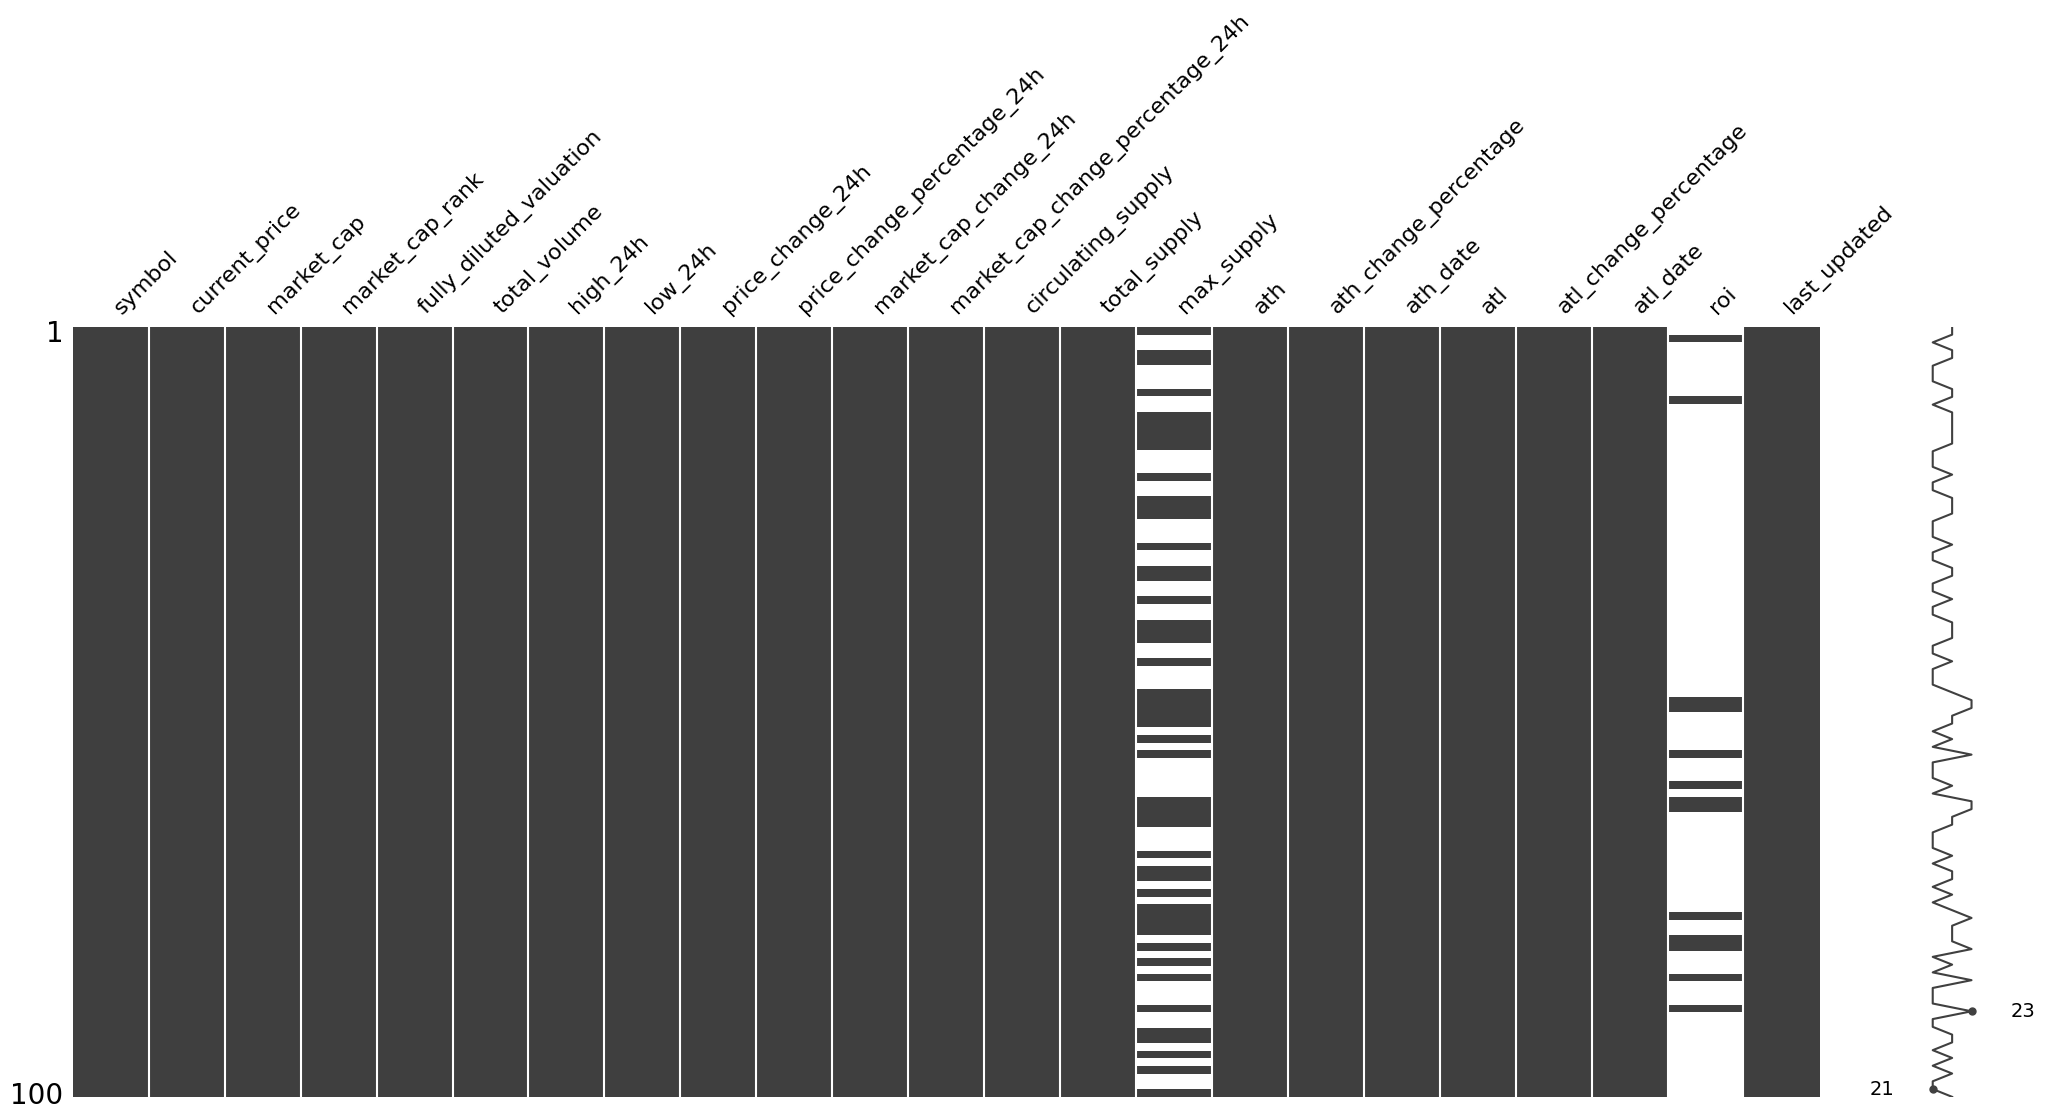

In [10]:
# Valores Faltantes
msno.matrix(df_criptos)

print(f"{Fore.BLUE}Porcentajes NaN de Columnas Numericas:{Style.RESET_ALL}")
for columna in df_criptos.isna().sum().index:
  if df_criptos[columna].isna().sum() > 0:
    print(f"{' '*3 + columna:<14}: {df_criptos[columna].isna().sum()/len(df_criptos)*100}")

print(f"\n{Fore.BLUE}Matriz de Valores Faltantes del Dataframe:{Style.RESET_ALL}")
plt.show()

In [11]:
# Valores Duplicados de Columnas Numericas
for columna in df_criptos.select_dtypes(exclude=["object"]):
  print(f"{columna:<33}: {df_criptos[columna].duplicated().sum()}")

print(f"""{Fore.BLUE}
            Nos interesa la columna max_supply ya que tiene muchos valores duplicados, pero
            visualizando la matriz de valores NaN, nos damos cuenta que no debemos eliminar sus valores duplicados,
            sino, debemos eliminar la columna entera ya que tiene muchos valores faltantes, no tiene sentido imputar
            la media u otro valor si tiene la columna mayor del 70% NaN.{Style.RESET_ALL}""")

current_price                    : 8
market_cap                       : 0
market_cap_rank                  : 0
fully_diluted_valuation          : 0
total_volume                     : 0
high_24h                         : 8
low_24h                          : 0
price_change_24h                 : 0
price_change_percentage_24h      : 0
market_cap_change_24h            : 0
market_cap_change_percentage_24h : 0
circulating_supply               : 0
total_supply                     : 9
max_supply                       : 67
ath                              : 1
ath_change_percentage            : 0
atl                              : 1
atl_change_percentage            : 0

            Nos interesa la columna max_supply ya que tiene muchos valores duplicados, pero
            visualizando la matriz de valores NaN, nos damos cuenta que no debemos eliminar sus valores duplicados,
            sino, debemos eliminar la columna entera ya que tiene muchos valores faltantes, no tiene sentido imputar
       

###2. Estructuracion

In [12]:
# Billones a Miles de Millones
for columna in df_criptos.select_dtypes(exclude="object"):
  if df_criptos[columna].max() >= 1e9:
    df_criptos[columna] = df_criptos[columna] / 1e9
    df_criptos.rename(columns={columna:f"{columna}_billion"}, inplace=True)

print(f"""{Fore.BLUE}
            En el dataset se observo valores muy grandes que posiblemente perjudiquen al analisis,
            por tal motivo, se transforman aquellos numeros mayores o iguales a un billon a la cifra
            de miles de millones porque es mas legible y es una escala estandar en finanzas. {Style.RESET_ALL}""")


            En el dataset se observo valores muy grandes que posiblemente perjudiquen al analisis,
            por tal motivo, se transforman aquellos numeros mayores o iguales a un billon a la cifra
            de miles de millones porque es mas legible y es una escala estandar en finanzas. 


###3. Limpieza

<Axes: >

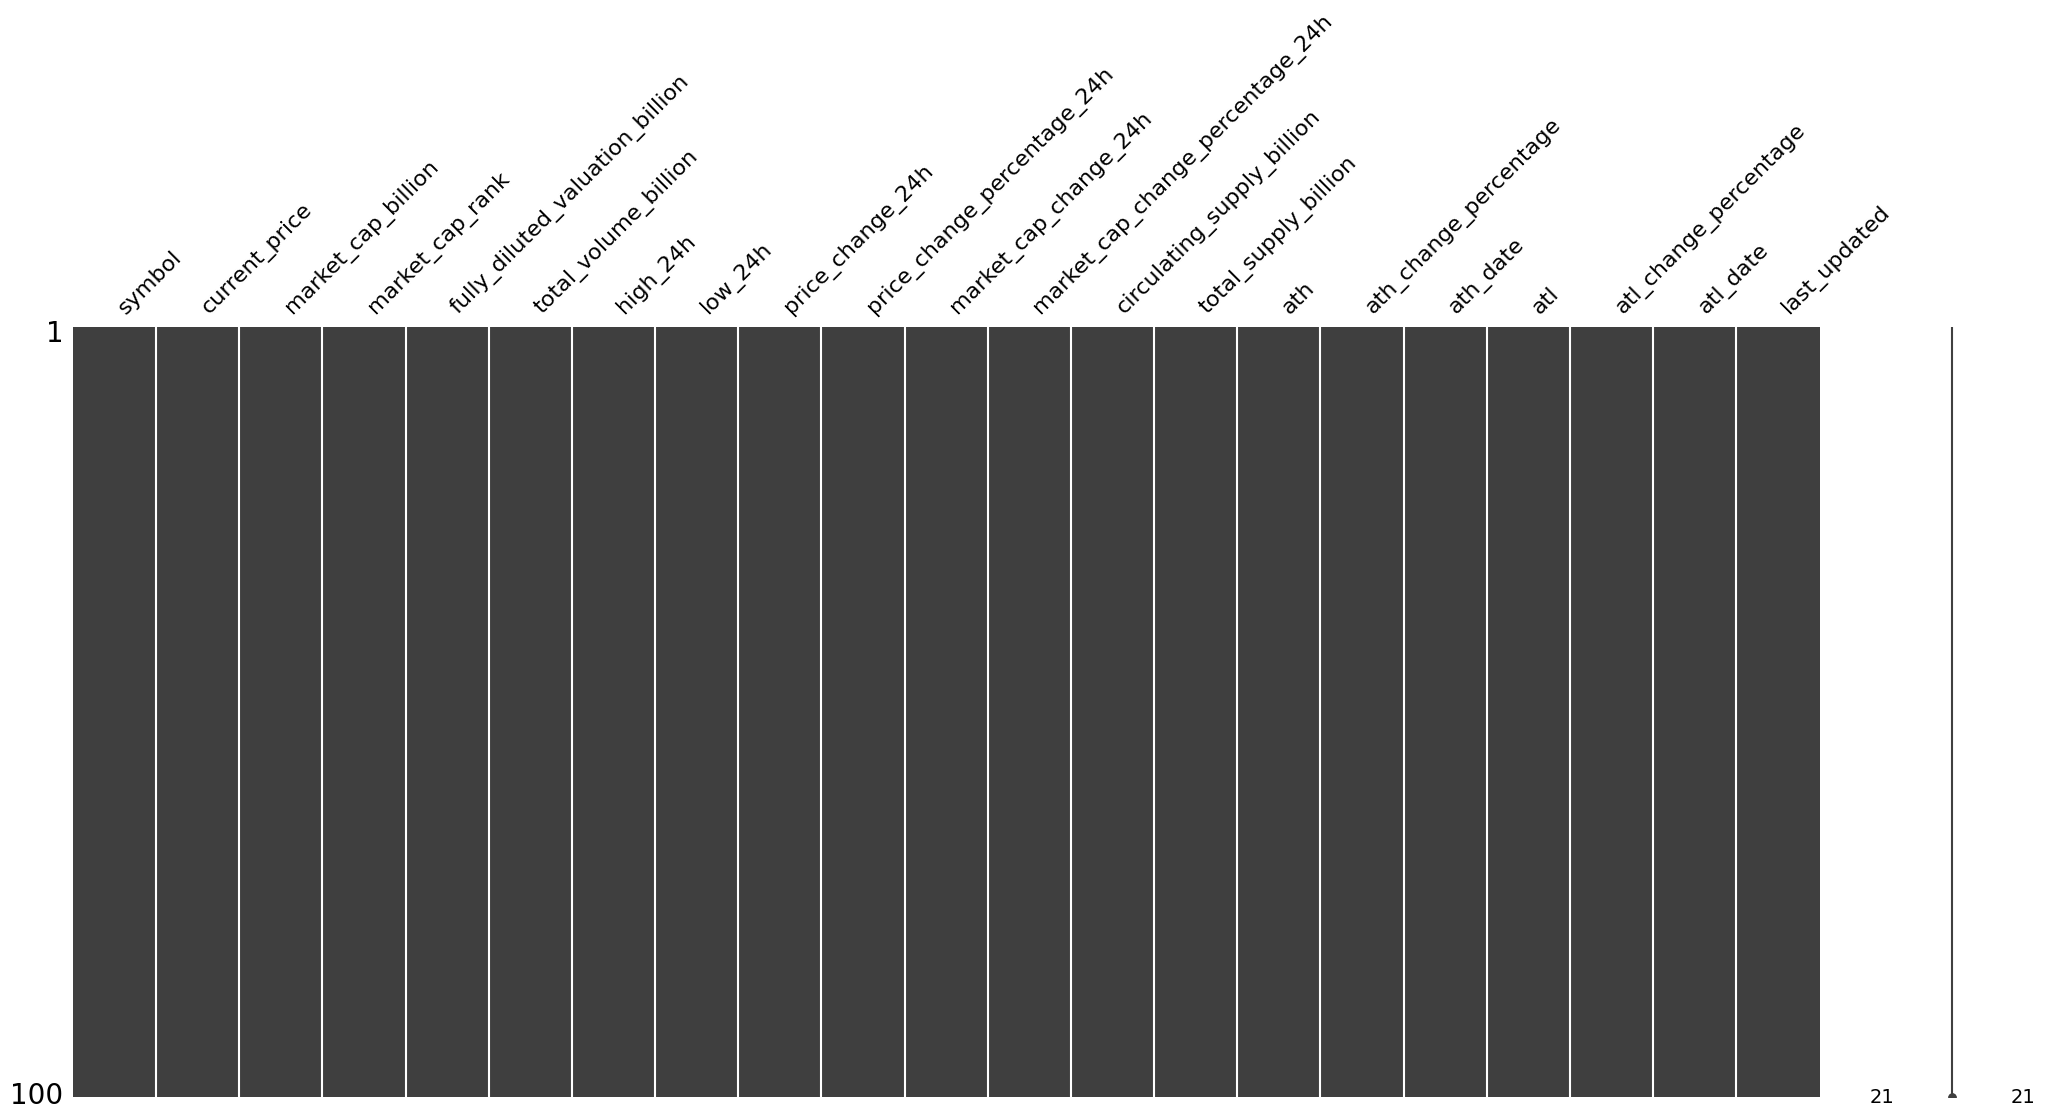

In [13]:
# Eliminar max_supply_billion y roi
df_criptos.drop(columns=["max_supply_billion","roi"], inplace=True)

msno.matrix(df_criptos)



---



###4. Enriquecimiento

In [44]:
np.random.seed(1)

df_criptos['Fraudulenta o no?'] = np.random.choice([0, 1], size=len(df_criptos), p=[0.95, 0.05])  # Aplicamos un 5% de fraude
df_criptos['Id_transaccion'] = np.random.randint(1000, 10000, size=len(df_criptos))  # Ids aleatorios
df_criptos['Fecha'] = pd.to_datetime('now') - pd.to_timedelta(np.random.randint(0, 365, size=len(df_criptos)), unit='D') # Fechas aleatorias en el último año

df_criptos['Monto'] = np.where(
    df_criptos["Fraudulenta o no?"] == 1, np.random.uniform(4.5, 5.0, size=len(df_criptos)), np.random.uniform(0.0001, 2.0, size=len(df_criptos))
) # Montos Coherentes aleatorios

df_criptos['Tipo de transaccion'] = np.random.choice(['Compra', 'Venta', 'Transferencia'], size=len(df_criptos))  # Tipos de transacción aleatorios

df_criptos.head(5)

,symbol,current_price,market_cap_billion,market_cap_rank,fully_diluted_valuation_billion,total_volume_billion,high_24h,low_24h,price_change_24h,price_change_percentage_24h,...,atl,atl_change_percentage,atl_date,last_updated,Fraudulenta o no?,Id_transaccion,Fecha,Monto,Tipo de transacción,Tipo de transaccion
0,btc,94641.00,1879.218623,1,1879.218623,27.416852,95193.00,93334.000000,-421.523715,-0.44342,...,67.810000,1.393841e+05,2013-07-06T00:00:00.000Z,2025-04-30T20:30:04.712Z,0,1020,2024-09-22 21:09:00.718046,0.091418,Transferencia,Transferencia
1,eth,1804.80,217.864299,2,217.864299,14.031837,1815.59,1750.280000,-10.782714,-0.59390,...,0.432979,4.169829e+05,2015-10-20T00:00:00.000Z,2025-04-30T20:30:38.715Z,0,7774,2025-03-10 21:09:00.718046,0.892254,Transferencia,Transferencia
2,usdt,1.00,148.425532,3,148.425532,42.617747,1.00,0.999922,-0.000209,-0.02089,...,0.572521,7.466987e+01,2015-03-02T00:00:00.000Z,2025-04-30T20:30:38.565Z,0,2968,2024-12-13 21:09:00.718046,1.936029,Compra,Compra
3,xrp,2.21,129.139955,4,220.930314,3.540291,2.28,2.150000,-0.074691,-3.26943,...,0.002686,8.208998e+04,2014-05-22T00:00:00.000Z,2025-04-30T20:29:54.192Z,0,7422,2024-12-28 21:09:00.718046,0.719185,Transferencia,Transferencia
4,bnb,599.60,87.474884,5,87.474884,0.755794,604.21,593.070000,-2.085128,-0.34655,...,0.039818,1.504897e+06,2017-10-19T00:00:00.000Z,2025-04-30T20:30:39.471Z,0,7629,2024-06-10 21:09:00.718046,1.108109,Compra,Compra


##Visualizaciones

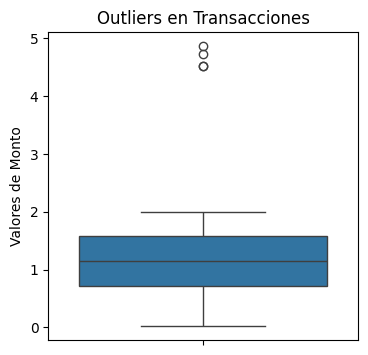

In [29]:
plt.figure(figsize=(4, 4))
sns.boxplot(y='Monto', data=df_criptos)
plt.title('Outliers en Transacciones')
plt.ylabel('Valores de Monto')
plt.show()

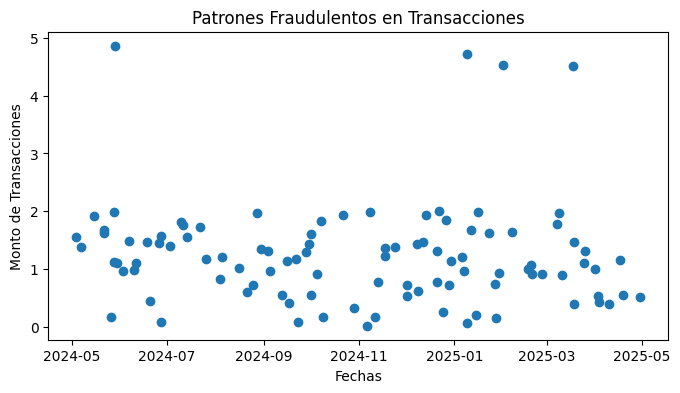

In [30]:
# Caracteristicas de las Transacciones que indican posible Fraude

plt.figure(figsize=(8,4))
plt.scatter(df_criptos["Fecha"], df_criptos["Monto"])
plt.xlabel("Fechas")
plt.ylabel("Monto de Transacciones")
plt.title("Patrones Fraudulentos en Transacciones")

plt.show()

Se observa outliers en los montos de las transacciones, las caracteristicas de patrones fraudulentos en transacciones son diversas, como valores muy elevados o muy bajos en corto tiempo. En este caso, a principios del 2025 se detectan estos patrones. Tambien ayudaria mucho investigar el horario de las transacciones fraudulentas realizadas y el tipo de transaccion (En general son ventas).

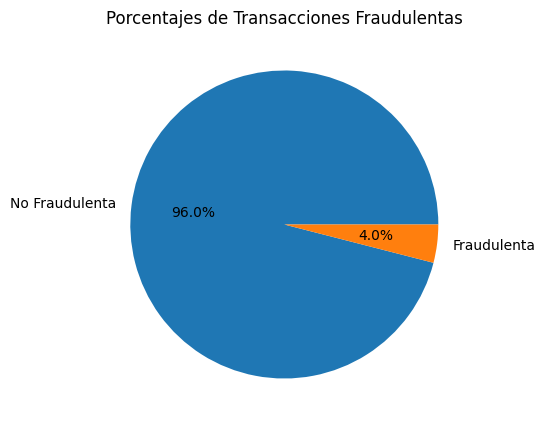

In [39]:
plt.figure(figsize=(5,5))
plt.pie(df_criptos["Fraudulenta o no?"].value_counts(),
        labels=["No Fraudulenta", "Fraudulenta"],
        autopct="%1.1f%%")
plt.title("Porcentajes de Transacciones Fraudulentas")

plt.show()

In [46]:
df_criptos[df_criptos["Fraudulenta o no?"] == 1][[
    "symbol","current_price","price_change_24h","total_volume_billion","Monto","Tipo de transaccion","Fecha"]]

,symbol,current_price,price_change_24h,total_volume_billion,Monto,Tipo de transaccion,Fecha
21,wsteth,2170.12,-8.903583,0.025874,4.515978,Transferencia,2025-03-17 21:09:00.718046
32,wbt,28.95,-0.187868,0.014246,4.721904,Venta,2025-01-08 21:09:00.718046
40,okb,51.24,-0.736939,0.005260,4.522209,Venta,2025-01-31 21:09:00.718046
87,ip,4.02,-0.101687,0.042642,4.861682,Compra,2024-05-28 21:09:00.718046


Estos datos de las transacciones fraudulentas permite conocer mas las razones por la cual hubo fraudes. En este caso podemos ver la volatilidad(price_change_24h), el volumen, su tipo de transaccion, etc. Datos claves para la toma de decisiones

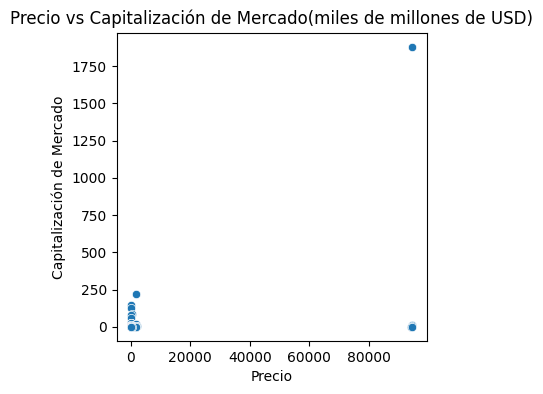

In [17]:
plt.figure(figsize=(4, 4))
sns.scatterplot(x='current_price', y='market_cap_billion', data=df_criptos)
plt.title('Precio vs Capitalización de Mercado(miles de millones de USD)')
plt.xlabel('Precio')
plt.ylabel('Capitalización de Mercado')
plt.show()

*  La mayoria de criptomonedas tienen bajo precio y capitalizacion, pero tambien existen criptos con alto precios y baja capitalizacion que indican tokens especulativos y el ultimo caso donde hay altos precios y capitalizacion que indican criptos dominantes en el mercado.

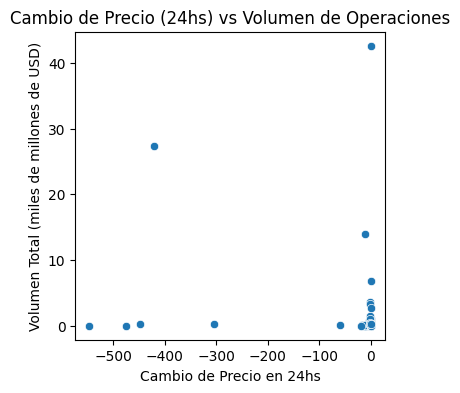

In [18]:
plt.figure(figsize=(4, 4))
sns.scatterplot(x='price_change_24h', y='total_volume_billion', data=df_criptos)
plt.title('Cambio de Precio (24hs) vs Volumen de Operaciones')
plt.xlabel('Cambio de Precio en 24hs')
plt.ylabel('Volumen Total (miles de millones de USD)')
plt.show()

*   Alta variación + alto volumen = interés real
*   Alta variación + bajo volumen = manipulación o poca liquidez
*   Bajo cambio + alto volumen = acumulación o estabilidad
*   Ambos bajos = desinterés o estancamiento

Se observa valores bajos en ambas variables, por lo que podemos decir que predomina el desinteres de ciertas criptomonedas

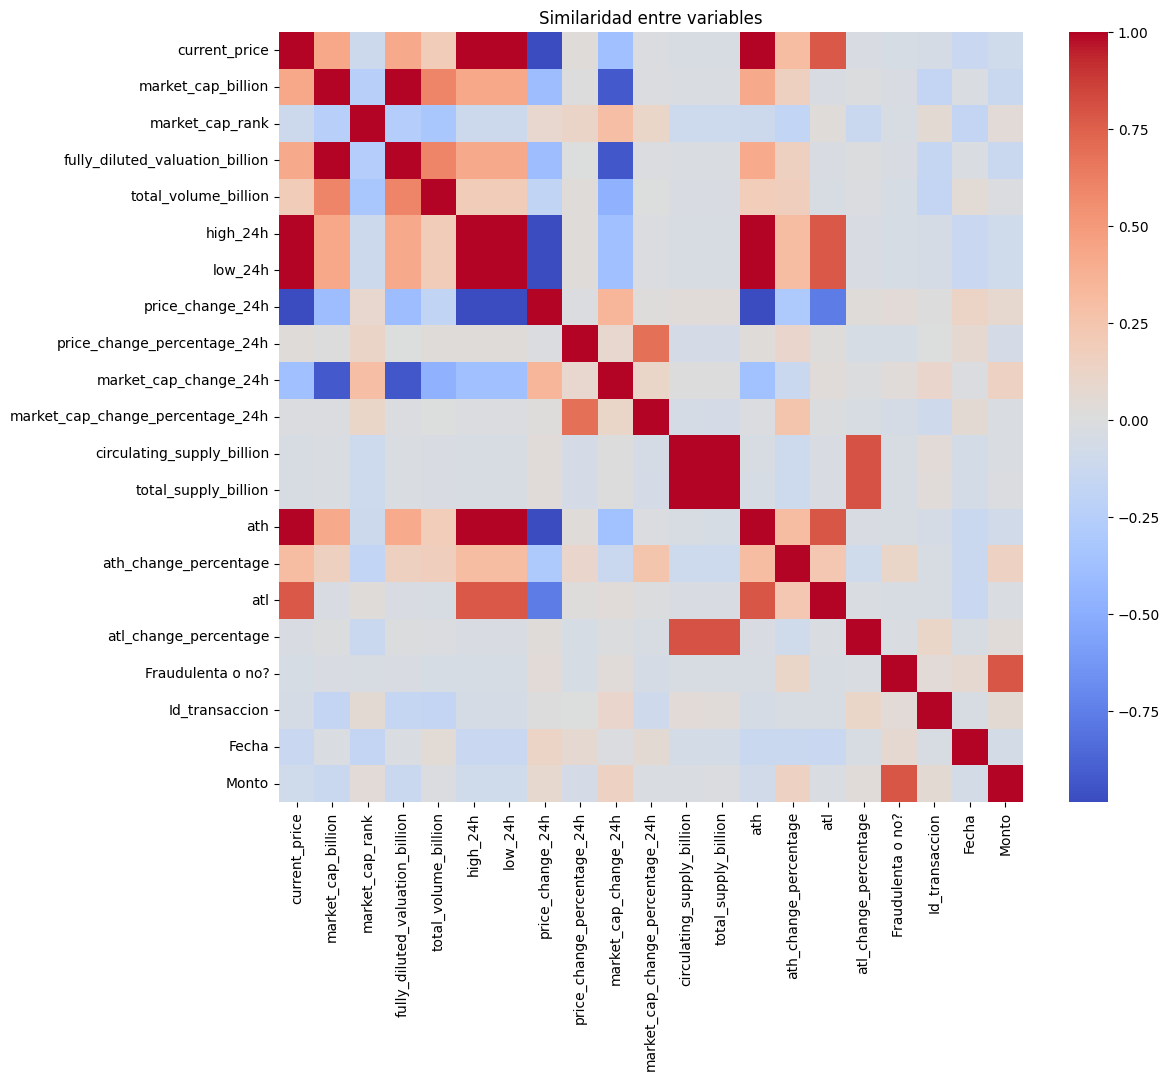

In [59]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_criptos.select_dtypes(exclude='object').corr(), annot=False, cmap='coolwarm')
plt.title('Similaridad entre variables')
plt.show()

*   Se observan bastantes similitudes entre variables, pero las mas importantes y que destacan son las que ayudan a encontrar posibles fraudes entre transacciones. Entonces, podemos decir que la mayoria de variables tiene una similitud alta con las demas, por lo que de alguna forma influye en el porque se estafo en esas criptomonedas

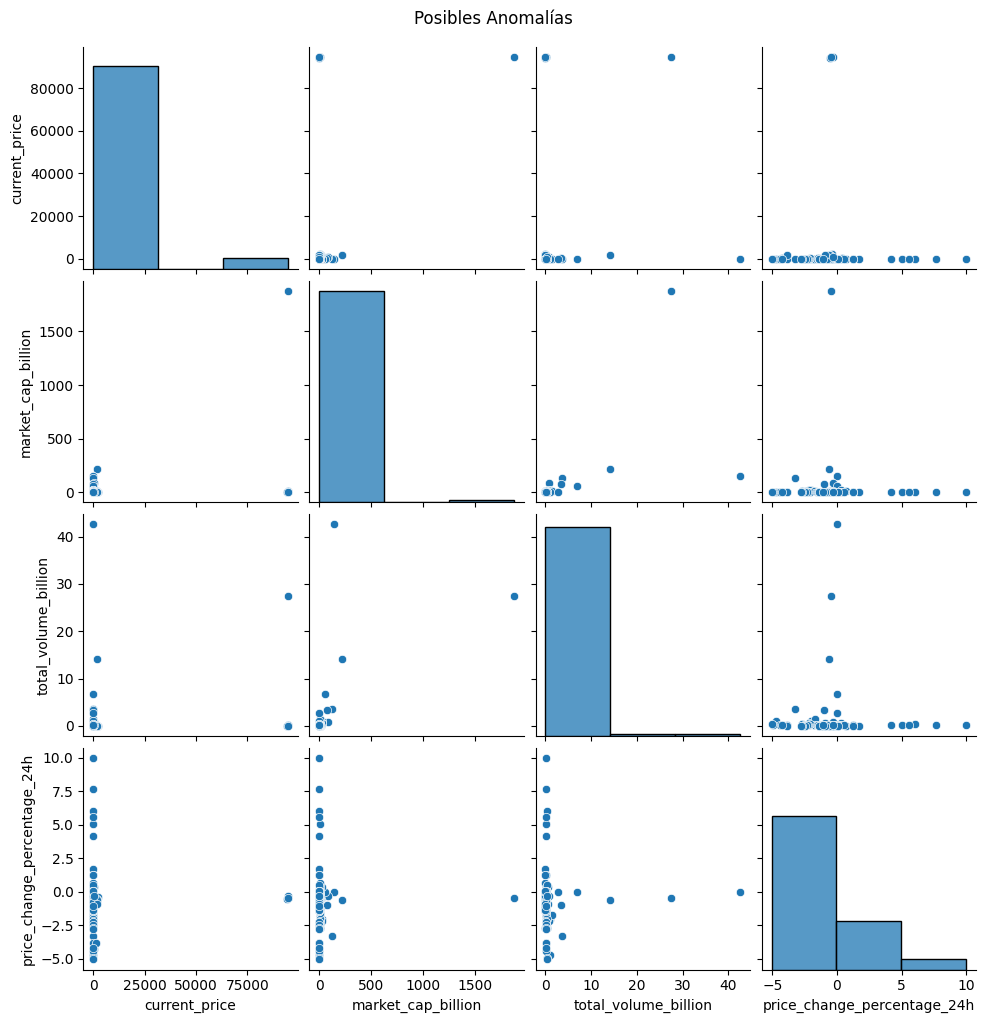

In [58]:
plot = sns.pairplot(df_criptos[[
    'current_price', 'market_cap_billion', 'total_volume_billion', 'price_change_percentage_24h'
]], diag_kind='hist', diag_kws={'bins': 3})

plot.fig.suptitle("Posibles Anomalías", y=1.02)  # No sobreponer el titulo en los graficos
plt.show()

#Conclusiones Finales

##Insights

*   Las criptomonedas fraudulentas son wsteth, wbt, okb, ip. Y constituyen un 4% de transacciones fraudulentas
*   Porque razones se estafo con esas Criptomonedas?: Generalmente cuando un año nuevo arranca, hay mas novatos metiendose en el mundo del blockchain, tambien por eventos significativos como "La moneda del presidente Milei que resulto una estafa"
*   2 transacciones fraudulentas son ventas, otra es transaccion y la ultima es compra. Generalmente el tipo de transaccion en estos casos, son ventas, ya que se busca estafar con precios altos
*  Los fraudes en este caso, tienen precios muy elevados y anormales, tambien podrian haber sido precios muy bajos.
*  Existen pocos casos de criptomonedas con tokens especulativos(alta volatilidad y riesgo) que su valor depende solamente de la demanda en tiempo real


##Mi sugerencia:

1. Monitoreo continuo de transacciones con características sospechosas

2. Implementar modelos predictivos

3. Visualización regular de datos para detectar anomalias tempranas

4. Validar y actualizar los datos constantemente

##Con respecto a la hipotesis:

Los eventos significativos a principios del 2025 como "$Libra de Milei" influyeron en los fraudes de las criptomonedas, porque lo que, la hipotesis cumplio ciertamente con su proposito. Tambien influyen otras y muchas variables pero una de las principales es esa.